<a href="https://colab.research.google.com/github/AlvarFeher/TFG/blob/main/GNN_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filename = "/content/drive/MyDrive/TFG/data/graph.pkl"
!pip install awkward pandas awkward-pandas

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import awkward as ak
import pandas as pd
import awkward_pandas as akpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pickle

# Load the graph from the file
with open(filename, "rb") as f:
    G = pickle.load(f)

# Check if the graph loaded correctly
print(f"Loaded Graph: {G}")
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")

# Check the attributes of a random node
random_node = list(G.nodes)[0]  # Pick a random node
print(f"Attributes of node {random_node}: {G.nodes[random_node]}")

Loaded Graph: DiGraph with 10770 nodes and 9660 edges
Number of Nodes: 10770
Number of Edges: 9660
Attributes of node (1439, 162, 0): {'row': 36.0, 'column': 0.0, 'energy': 6113.748046875, 'type': 'seed', 'MCID': 321.0}


In [ ]:
# Install PyTorch Geometric and dependencies
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00


In [ ]:
import torch
import networkx as nx
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data

# Convert NetworkX DiGraph to PyTorch Geometric format
data = from_networkx(G)

# Print the graph data
print(data)

import numpy as np

# Extract node features (energy, row, column)
node_features = []
node_labels = []

for node in G.nodes(data=True):
    node_id = node[0]
    features = [
        node[1].get("energy", 0),  # Energy value
        node[1].get("row", 0),  # Position row
        node[1].get("column", 0),  # Position column
    ]
    node_features.append(features)

    # Convert MCID into a label (0 = Photon, 1 = Other particles)
    mcid = node[1].get("MCID", -1)
    label = 0 if mcid == 22 else 1
    node_labels.append(label)

# Convert to PyTorch tensors
data.x = torch.tensor(node_features, dtype=torch.float)
data.y = torch.tensor(node_labels, dtype=torch.long)

print("Node Features Shape:", data.x.shape)
print("Labels Shape:", data.y.shape)


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

Data(edge_index=[2, 9660], row=[10770], column=[10770], energy=[10770], type=[10770], MCID=[10770], weight=[9660], num_nodes=10770)
Node Features Shape: torch.Size([10770, 3])
Labels Shape: torch.Size([10770])


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define the model parameters
input_dim = data.x.shape[1]  # Number of node features
hidden_dim = 32  # Hidden layer size
output_dim = 2  # Number of classes (Photon = 0, Other = 1)

# Initialize the model
model = GNNClassifier(input_dim, hidden_dim, output_dim)
print(model)


GNNClassifier(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 2)
)


In [ ]:
import torch.optim as optim

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

# Create a mask for training nodes (80% of nodes)
num_nodes = data.num_nodes
train_mask = torch.rand(num_nodes) < 0.8  # 80% train, 20% test
test_mask = ~train_mask

# Train the GNN
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])  # Compute loss
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

print("Training Complete.")


Epoch 0, Loss: 5.9853
Epoch 20, Loss: 1.2774
Epoch 40, Loss: 0.5914
Epoch 60, Loss: 0.8712
Epoch 80, Loss: 0.4904
Epoch 100, Loss: 0.5202
Epoch 120, Loss: 0.5443
Epoch 140, Loss: 0.5164
Epoch 160, Loss: 0.4825
Epoch 180, Loss: 0.4688
Training Complete.


In [ ]:
# Evaluate the trained model
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)  # Get predicted class for each node

# Compute accuracy
correct = (pred[test_mask] == data.y[test_mask]).sum().item()
accuracy = correct / test_mask.sum().item()

print(f"Test Accuracy: {accuracy:.2%}")


Test Accuracy: 80.13%


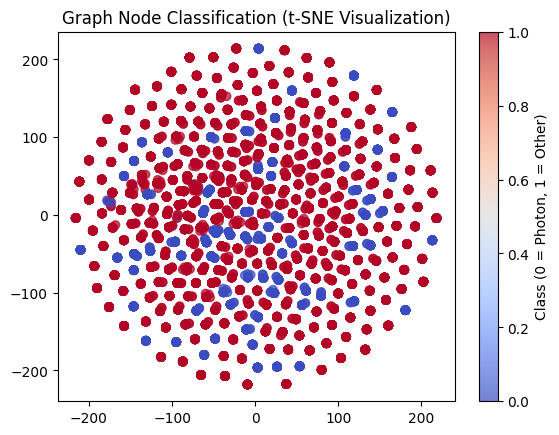

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract node embeddings from the first GNN layer
embeddings = model.conv1(data.x, data.edge_index).detach().numpy()

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
low_dim_embeddings = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.scatter(low_dim_embeddings[:, 0], low_dim_embeddings[:, 1], c=data.y.numpy(), cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Class (0 = Photon, 1 = Other)")
plt.title("Graph Node Classification (t-SNE Visualization)")
plt.show()
